## Дашборд конверсий

Скрипт для работы с API и базой данных

In [195]:
from dotenv import load_dotenv
import os
import requests

import matplotlib.pyplot as plt
import pandas as pd

In [196]:
# Загрузка переменных из окружения
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

### Сбор данных

In [197]:
# Получение данных о посещениях по API
visits_response = requests.get(f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}')

visits_response

<Response [200]>

In [198]:
# Получение данных о регистрациях по API
registrations_response = requests.get(f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}')

registrations_response

<Response [200]>

In [199]:
# Создание датафрейма с данными о посещениях
visits_df = pd.DataFrame(visits_response.json())

visits_df.head()

,datetime,platform,user_agent,visit_id
0,"Wed, 01 Mar 2023 10:36:22 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1de9ea66-70d3-4a1f-8735-df5ef7697fb9
1,"Wed, 01 Mar 2023 06:25:00 GMT",web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,f149f542-e935-4870-9734-6b4501eaf614
2,"Wed, 01 Mar 2023 10:26:13 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1
3,"Wed, 01 Mar 2023 12:33:06 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,19322fed-157c-49c6-b16e-2d5cabeb9592
4,"Wed, 01 Mar 2023 01:38:35 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,04762a22-3c9f-40c9-9ac9-6628c4381836


In [200]:
# Создание датафрейма с данными о регистрациях
registrations_df = pd.DataFrame(registrations_response.json())

registrations_df.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 07:40:13 GMT",ebyrd@example.org,web,google,2e0f6bb8-b029-4f45-a786-2b53990d37f1
1,"Wed, 01 Mar 2023 13:14:00 GMT",knightgerald@example.org,web,email,f007f97c-9d8b-48b5-af08-119bb8f6d9b6
2,"Wed, 01 Mar 2023 03:05:50 GMT",cherylthompson@example.com,web,apple,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15
3,"Wed, 01 Mar 2023 00:04:47 GMT",halldavid@example.org,web,email,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60
4,"Wed, 01 Mar 2023 18:31:52 GMT",denise86@example.net,web,google,27f875fc-f8ce-4aeb-8722-0ecb283d0760


### Подготовка и очистка данных

In [201]:
# Создание копий датафреймов для дальнейшей обработки
visits_copy_df = visits_df.copy()
registrations_copy_df = registrations_df.copy()

In [202]:
# Подготовка данных о посещениях
bot_keyword = 'bot'

visits_copy_df = visits_copy_df[~visits_copy_df['user_agent'].str.contains(bot_keyword)]
visits_copy_df['datetime'] = pd.to_datetime(visits_copy_df['datetime']).dt.date

visits_copy_df.sort_values('datetime')
visits_copy_df = visits_copy_df.drop_duplicates('visit_id')

visits_copy_df = visits_copy_df.groupby(['datetime', 'platform']).agg({'visit_id': 'count'})
visits_copy_df = visits_copy_df.reset_index()

visits_copy_df.head()

,datetime,platform,visit_id
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31


In [203]:
# Подготовка данных о регистрациях
registrations_copy_df['datetime'] = pd.to_datetime(registrations_copy_df['datetime']).dt.date

registrations_copy_df = registrations_copy_df.groupby(['datetime', 'platform']).agg({'user_id': 'count'})
registrations_copy_df = registrations_copy_df.reset_index()

registrations_copy_df.head()

,datetime,platform,user_id
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24


In [204]:
# Объединение данных о посещениях и регистрациях
keys = [
    'datetime',
    'platform'
]
conversion_rate_df = pd.merge(
    visits_copy_df, 
    registrations_copy_df, 
    on=keys, 
    how='right'
)
columns = {
    'datetime': 'date_group',
    'visit_id': 'visits',
    'user_id': 'registrations'
}
conversion_rate_df = conversion_rate_df.rename(columns=columns)

conversion_rate_df.head()

,date_group,platform,visits,registrations
0,2023-03-01,android,75,61
1,2023-03-01,ios,22,18
2,2023-03-01,web,279,8
3,2023-03-02,android,67,59
4,2023-03-02,ios,31,24


### Расчет метрик

In [205]:
# Расчет конверсии визитов в регистрации
conversion_rate_df['conversion'] = conversion_rate_df['registrations'] / conversion_rate_df['visits'] * 100

conversion_rate_df.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


In [206]:
# Экспорт в json
conversion_rate_df.to_json('conversion.json')

### Добавление данных о рекламе

In [207]:
# Создание датафрема с данными о рекламе
advertisement_df = pd.read_csv('ads.csv')

advertisement_df.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265


In [208]:
# Подготовка данных по рекламе
columns = {'date': 'date_group'}
advertisement_df['date'] = pd.to_datetime(advertisement_df['date']).dt.date
advertisement_df = advertisement_df.rename(columns=columns)

advertisement_df.head()

,date_group,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265


In [209]:
# Объединение данных
visits_registrations_grouped_df = conversion_rate_df.groupby(['date_group']).agg({'registrations': 'sum', 'visits': 'sum'})
visits_registrations_grouped_df = visits_registrations_grouped_df.reset_index()

united_df = pd.merge(visits_registrations_grouped_df, advertisement_df, on='date_group', how='left')
united_df['cost'] = united_df['cost'].fillna(0)
united_df['utm_campaign'] = united_df['utm_campaign'].fillna('none')
united_df = united_df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

united_df.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,616,106,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,648,159,223.0,advanced_algorithms_series
4,2023-03-05,711,115,265.0,advanced_algorithms_series


In [210]:
# Экспорт в json
united_df.to_json('ads.json')

### Визуализация

In [211]:
# Создание директории для графиков
if not os.path.exists('charts'):
    os.makedirs('charts')

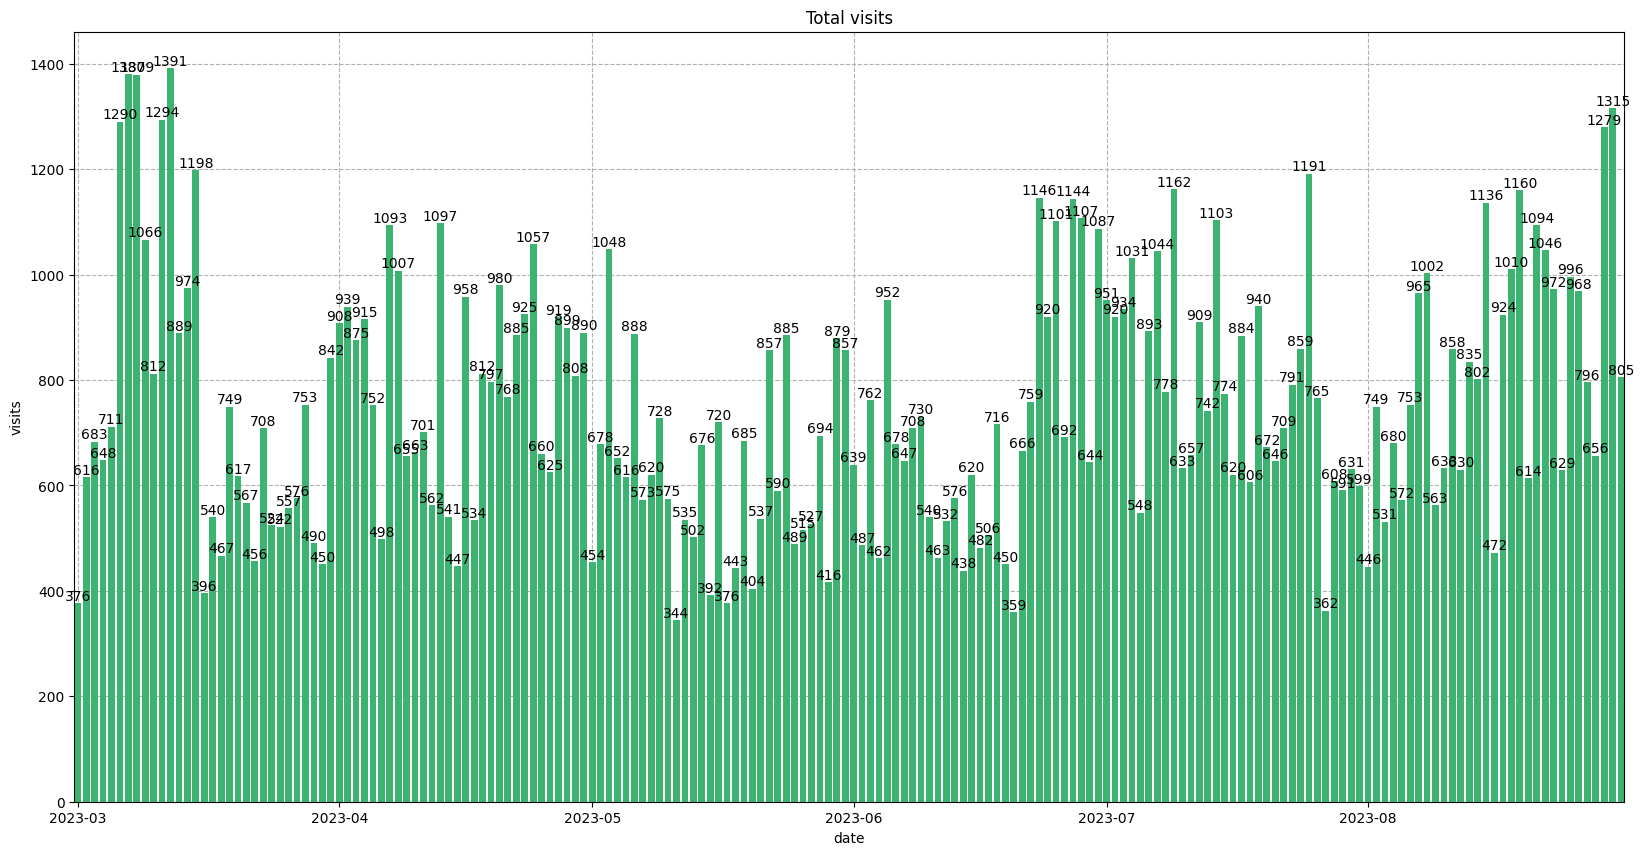

In [212]:
# Итоговые визиты
x = united_df['date_group']
y = united_df['visits']

fig, ax = plt.subplots(figsize=(20, 10))

tota_visits_plot = ax.bar(x, y, color='mediumseagreen')

for bar in tota_visits_plot:
    y = bar.get_height()
    ax.annotate(f"{y}", xy=(bar.get_x() + bar.get_width() / 2, y), xytext=(0, 0), textcoords="offset points", ha='center', va='bottom')

ax.set_title('Total visits')
ax.set_xlabel('date')
ax.set_ylabel('visits')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)

plt.savefig('charts/fig01.png', format='png')

plt.show()

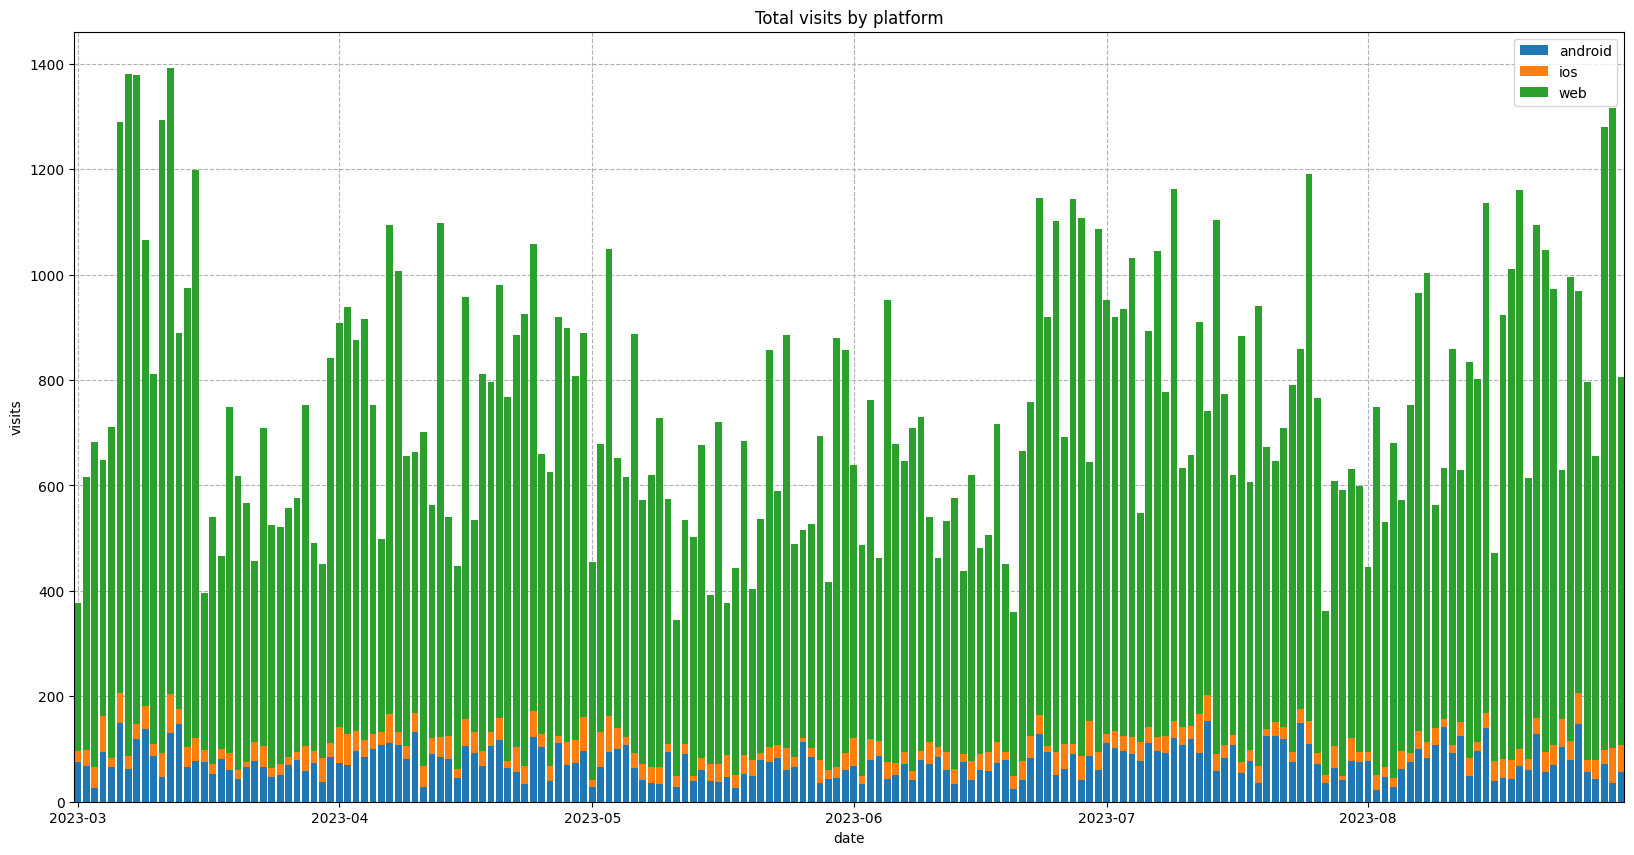

In [213]:
# Итоговые визиты с разбивкой по платформе
android_df = conversion_rate_df[conversion_rate_df['platform'] == 'android'].reset_index()
ios_df = conversion_rate_df[conversion_rate_df['platform'] == 'ios'].reset_index()
web_df = conversion_rate_df[conversion_rate_df['platform'] == 'web'].reset_index()

x = android_df['date_group']
y_1 = android_df['visits']
y_2 = ios_df['visits']
y_3 = web_df['visits']

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(x, y_1, label='android')
ax.bar(x, y_2, bottom=y_1, label='ios')
ax.bar(x, y_3, bottom=np.add(y_1, y_2), label='web')

ax.set_title('Total visits by platform')
ax.set_xlabel('date')
ax.set_ylabel('visits')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)
ax.legend()

plt.savefig('charts/fig02.png', format='png')

plt.show()

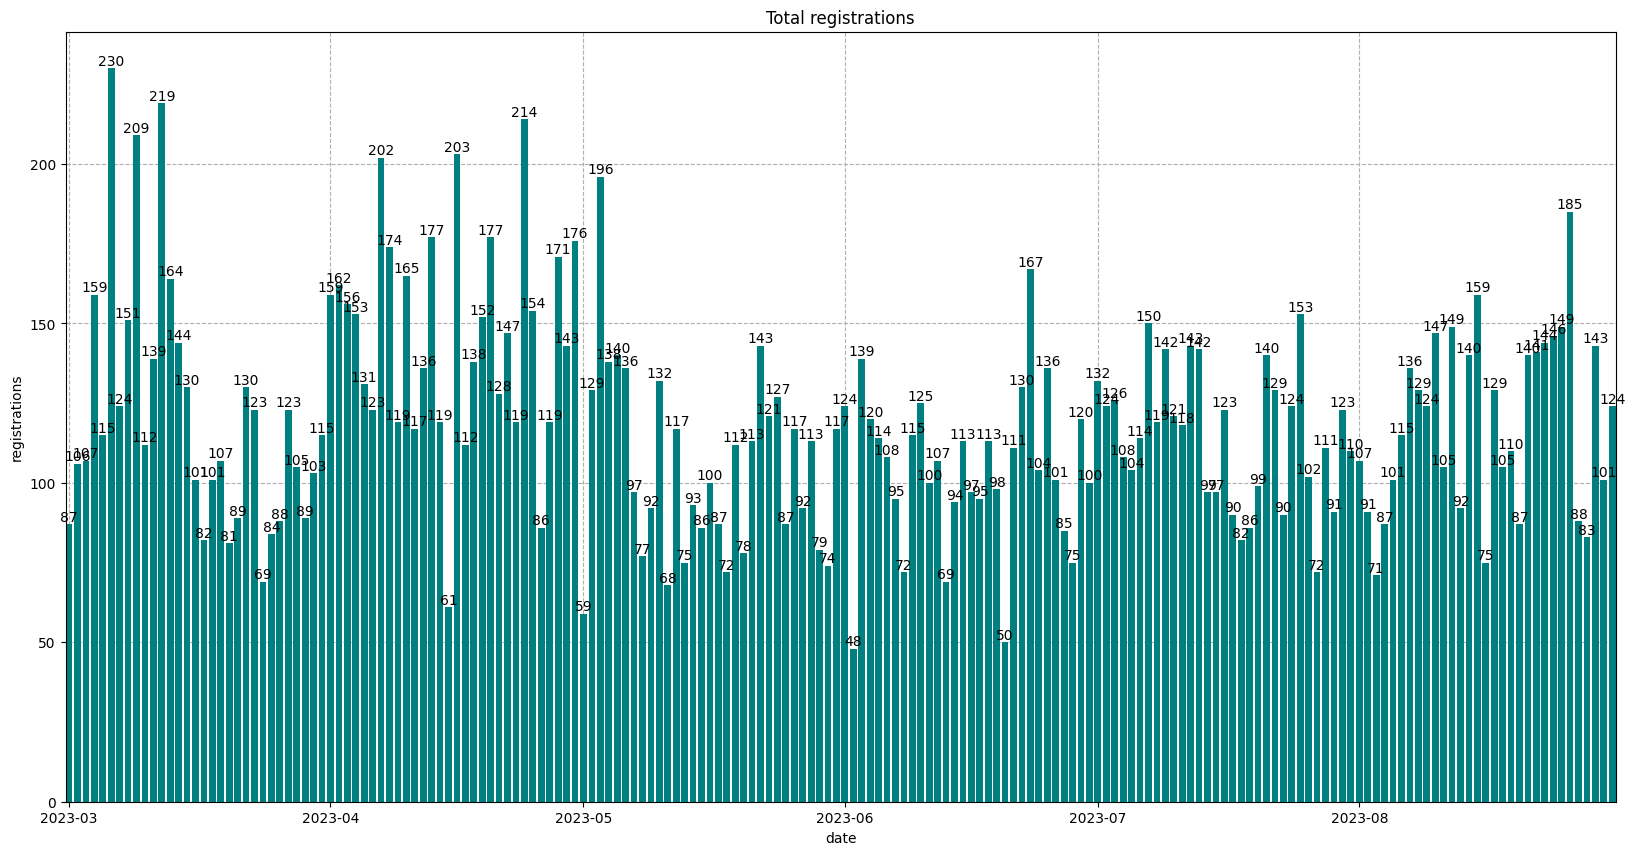

In [214]:
# Итоговые регистрации
x = united_df['date_group']
y = united_df['registrations']

fig, ax = plt.subplots(figsize=(20, 10))

tota_registrations_plot = ax.bar(x, y, color='teal')

for bar in tota_registrations_plot:
    y = bar.get_height()
    ax.annotate(f"{y}", xy=(bar.get_x() + bar.get_width() / 2, y), xytext=(0, 0), textcoords="offset points", ha='center', va='bottom')

ax.set_title('Total registrations')
ax.set_xlabel('date')
ax.set_ylabel('registrations')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)

plt.savefig('charts/fig03.png', format='png')

plt.show()

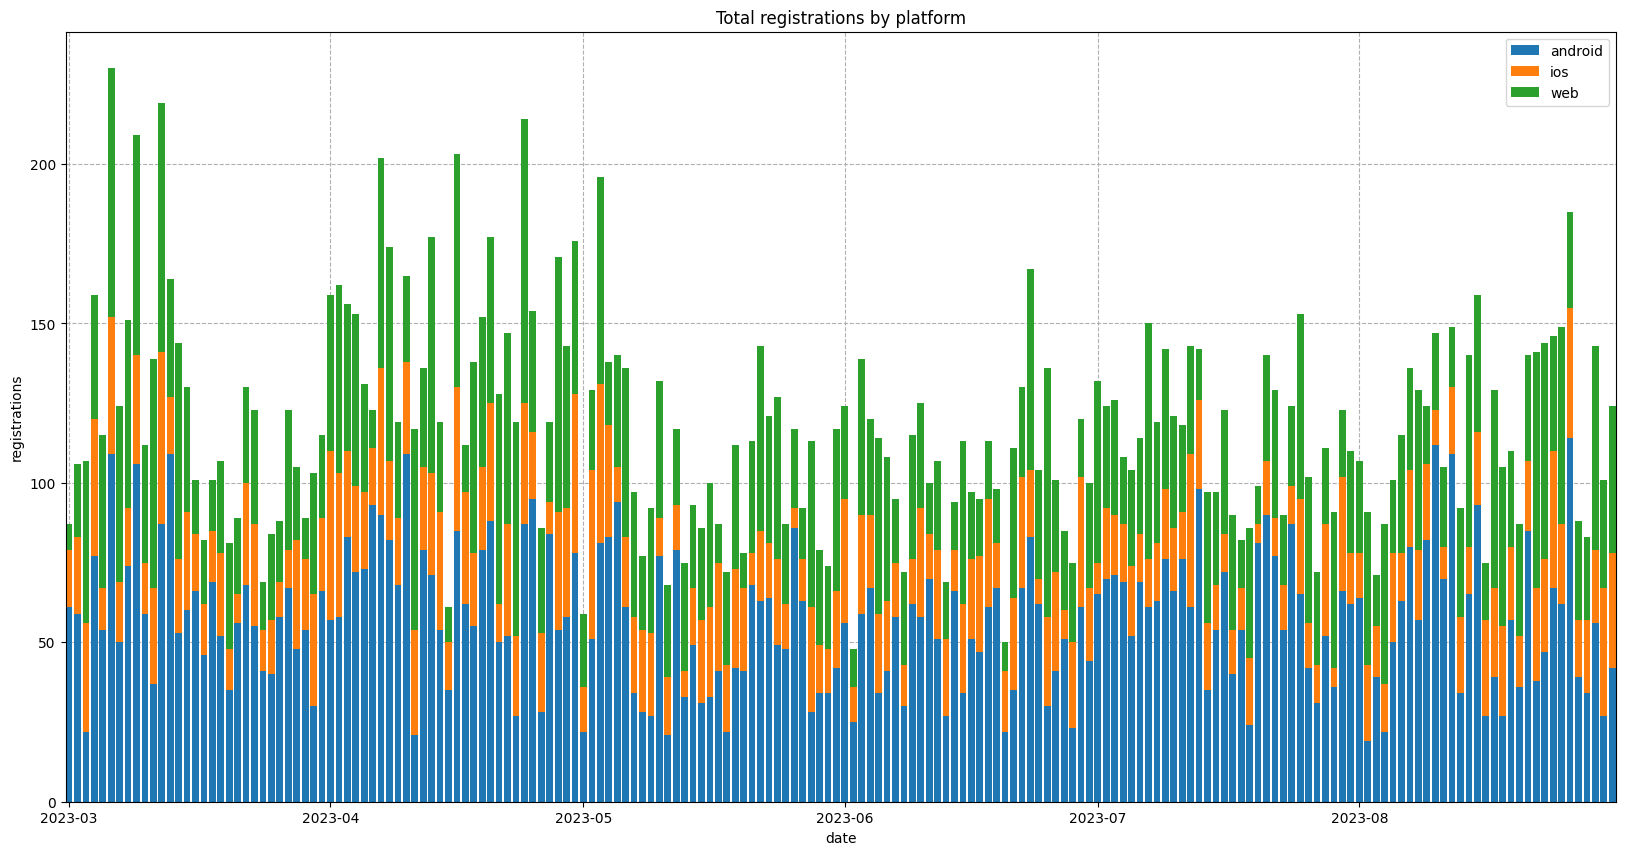

In [215]:
# Итоговые регистрации с разбивкой по платформе
android_df = conversion_rate_df[conversion_rate_df['platform'] == 'android'].reset_index()
ios_df = conversion_rate_df[conversion_rate_df['platform'] == 'ios'].reset_index()
web_df = conversion_rate_df[conversion_rate_df['platform'] == 'web'].reset_index()

x = android_df['date_group']
y_1 = android_df['registrations']
y_2 = ios_df['registrations']
y_3 = web_df['registrations']

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(x, y_1, label='android')
ax.bar(x, y_2, bottom=y_1, label='ios')
ax.bar(x, y_3, bottom=np.add(y_1, y_2), label='web')

ax.set_title('Total registrations by platform')
ax.set_xlabel('date')
ax.set_ylabel('registrations')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)
ax.legend()

plt.savefig('charts/fig04.png', format='png')

plt.show()

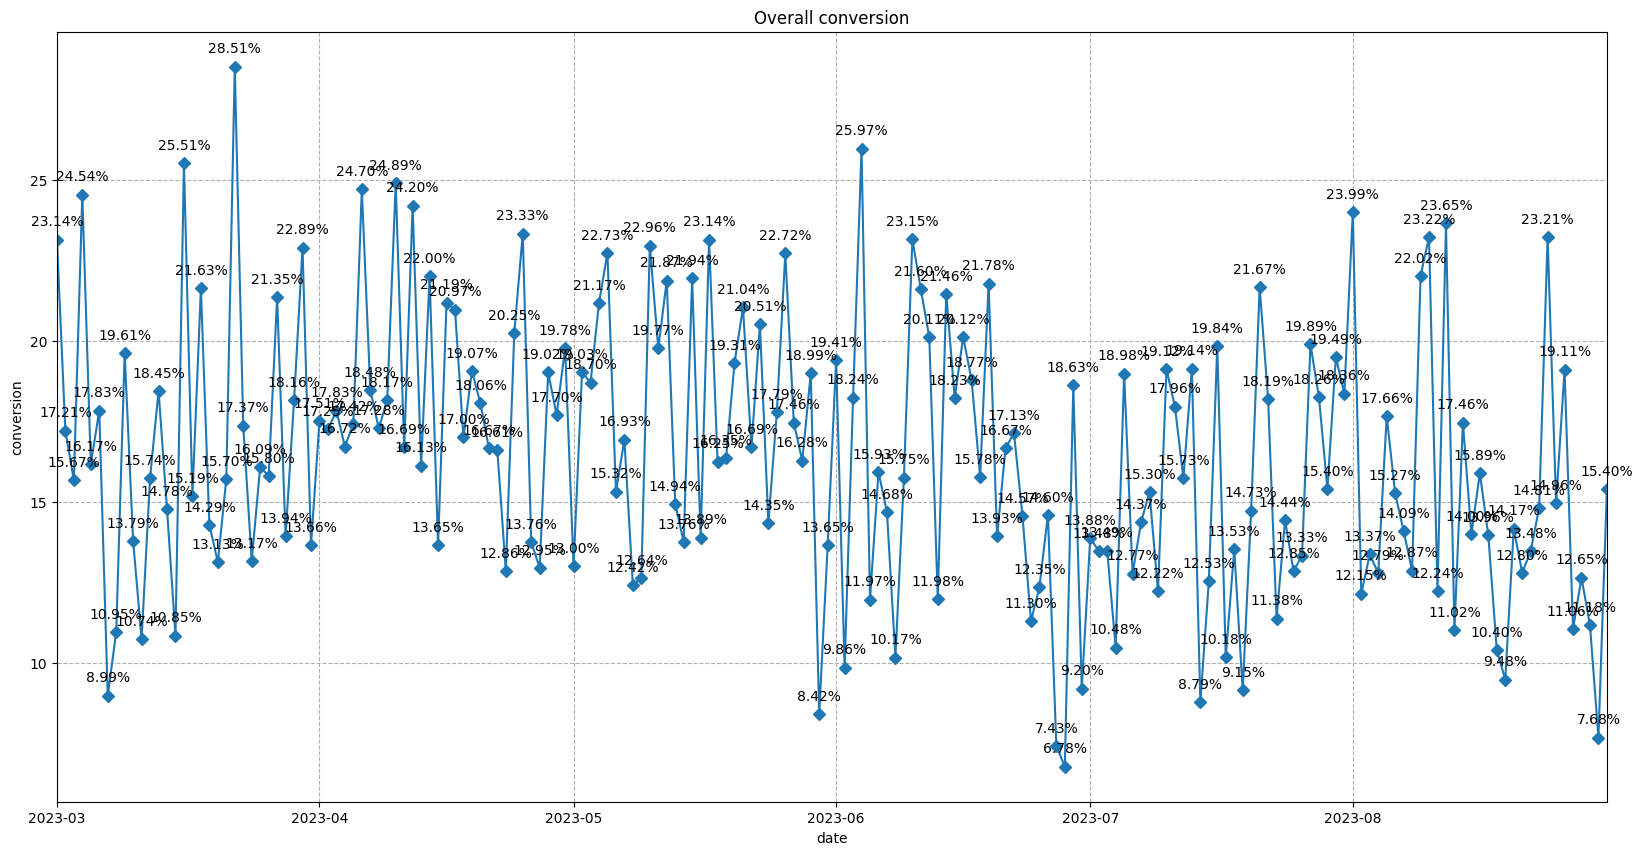

In [216]:
# Итоговые конверсии
overall_conversion_df = conversion_rate_df.groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
overall_conversion_df['conversion'] = round(overall_conversion_df['registrations'] / overall_conversion_df['visits'] * 100, 2)
overall_conversion_df = overall_conversion_df.reset_index()

x = overall_conversion_df['date_group']
y = overall_conversion_df['conversion']

fig, ax = plt.subplots(figsize=(20, 10))

overall_conversion_plot = ax.plot(x, y, marker='D')

for x, y in zip(x, y):

    label = '{:.2f}%'.format(y)

    ax.annotate(label, 
                 (x, y),
                 textcoords='offset points',
                 xytext=(0,10),
                 ha='center')

ax.set_title('Overall conversion')
ax.set_xlabel('date')
ax.set_ylabel('conversion')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)

plt.savefig('charts/fig05.png', format='png')

plt.show()

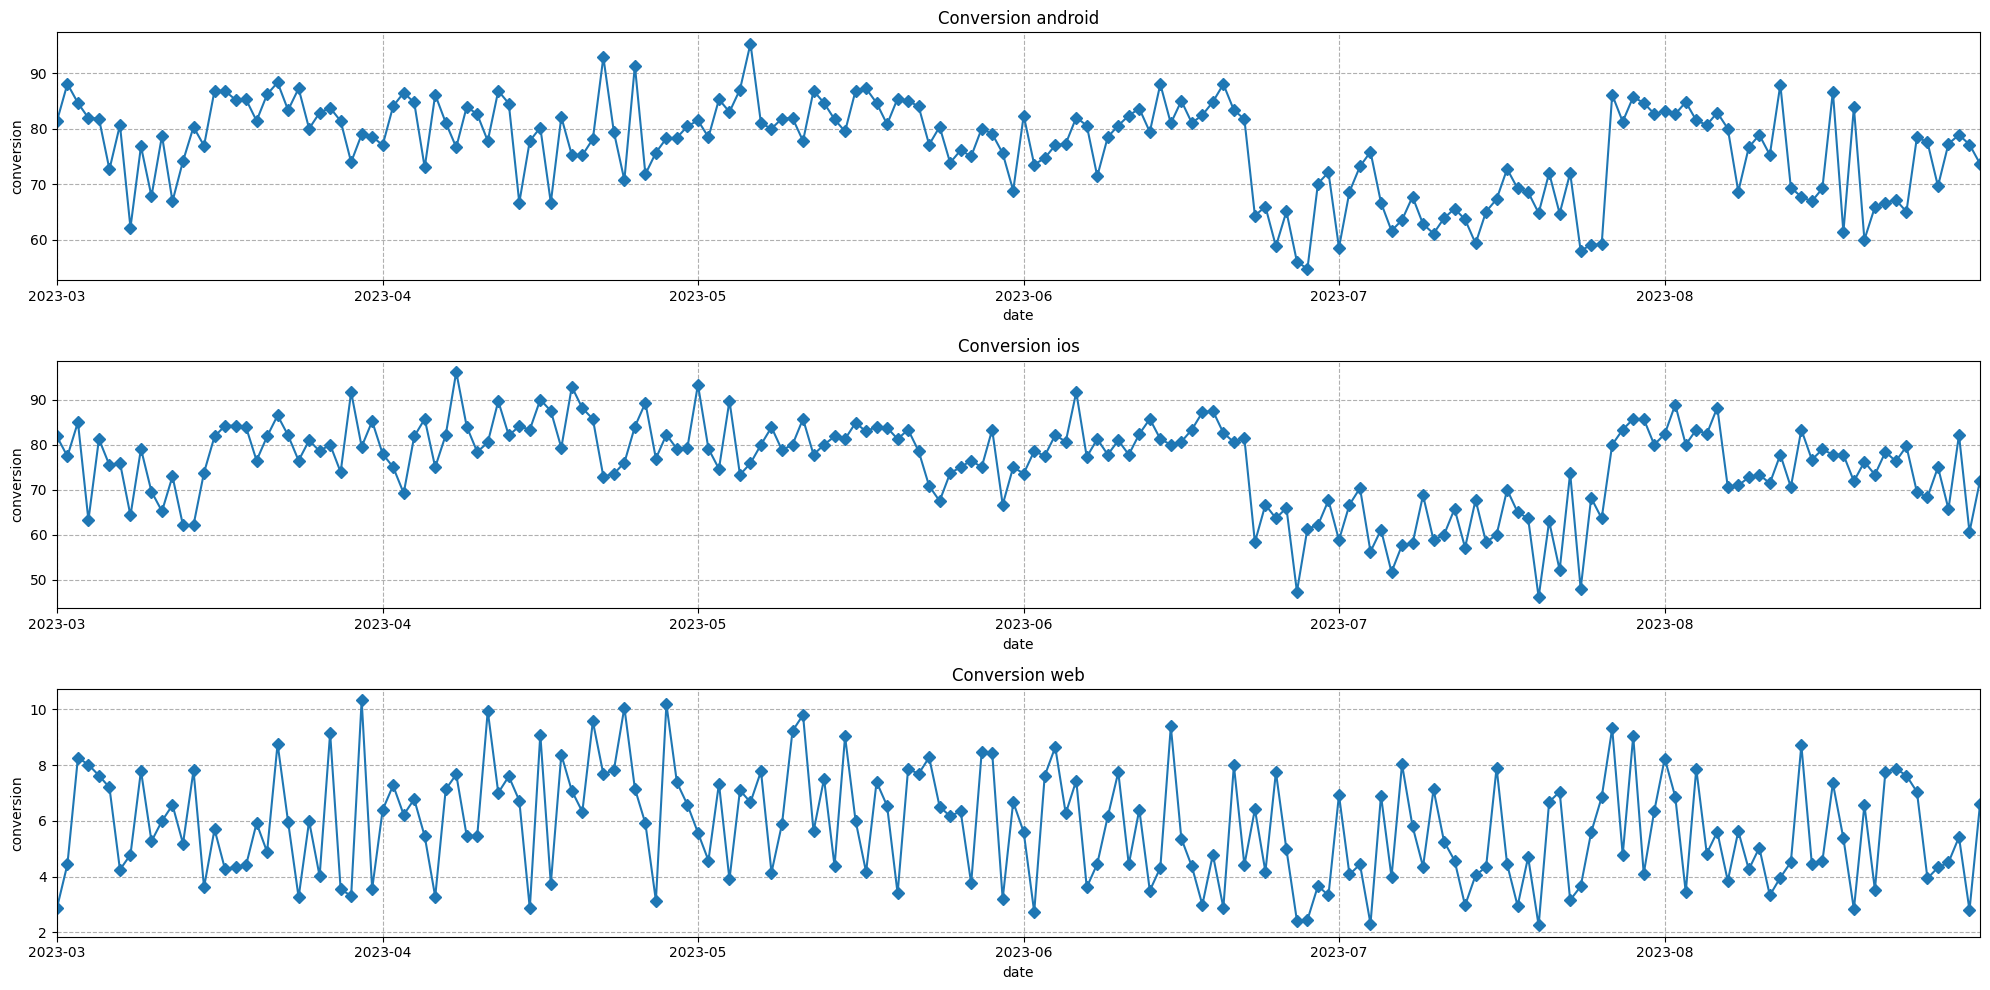

In [217]:
# Конверсия по каждой платформе
android_conversion_df = conversion_rate_df.loc[conversion_rate_df['platform'] == 'android'].groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
android_conversion_df['conversion'] = round(android_conversion_df['registrations'] / android_conversion_df['visits'] * 100, 2)
android_conversion_df = android_conversion_df.reset_index()

ios_conversion_df = conversion_rate_df.loc[conversion_rate_df['platform'] == 'ios'].groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
ios_conversion_df['conversion'] = round(ios_conversion_df['registrations'] / ios_conversion_df['visits'] * 100, 2)
ios_conversion_df = ios_conversion_df.reset_index()

web_conversion_df = conversion_rate_df.loc[conversion_rate_df['platform'] == 'web']
web_conversion_df = web_conversion_df.groupby(['date_group']).agg({'visits': 'sum', 'registrations': 'sum'})
web_conversion_df['conversion'] = round(web_conversion_df['registrations'] / web_conversion_df['visits'] * 100, 2)
web_conversion_df = web_conversion_df.reset_index()

x = android_conversion_df['date_group']
y_1 = android_conversion_df['conversion']
y_2 = ios_conversion_df['conversion']
y_3 = web_conversion_df['conversion']

fig, ax = plt.subplots(figsize=(20, 10), nrows=3, ncols=1, layout='tight')

ax[0].set_title('Conversion android')
ax[0].plot(x, y_1, marker='D')
ax[0].set_xlabel('date')
ax[0].set_ylabel('conversion')
ax[0].grid(True)
ax[0].margins(x=0)
ax[0].grid(True, linestyle='dashed')
ax[0].set_axisbelow(True)

ax[1].set_title('Conversion ios')
ax[1].plot(x, y_2, marker='D')
ax[1].set_xlabel('date')
ax[1].set_ylabel('conversion')
ax[1].grid(True)
ax[1].margins(x=0)
ax[1].grid(True, linestyle='dashed')
ax[1].set_axisbelow(True)

ax[2].set_title('Conversion web')
ax[2].plot(x, y_3, marker='D')
ax[2].set_xlabel('date')
ax[2].set_ylabel('conversion')
ax[2].grid(True)
ax[2].margins(x=0)
ax[2].grid(True, linestyle='dashed')
ax[2].set_axisbelow(True)

plt.savefig('charts/fig06.png', format='png')

plt.show()

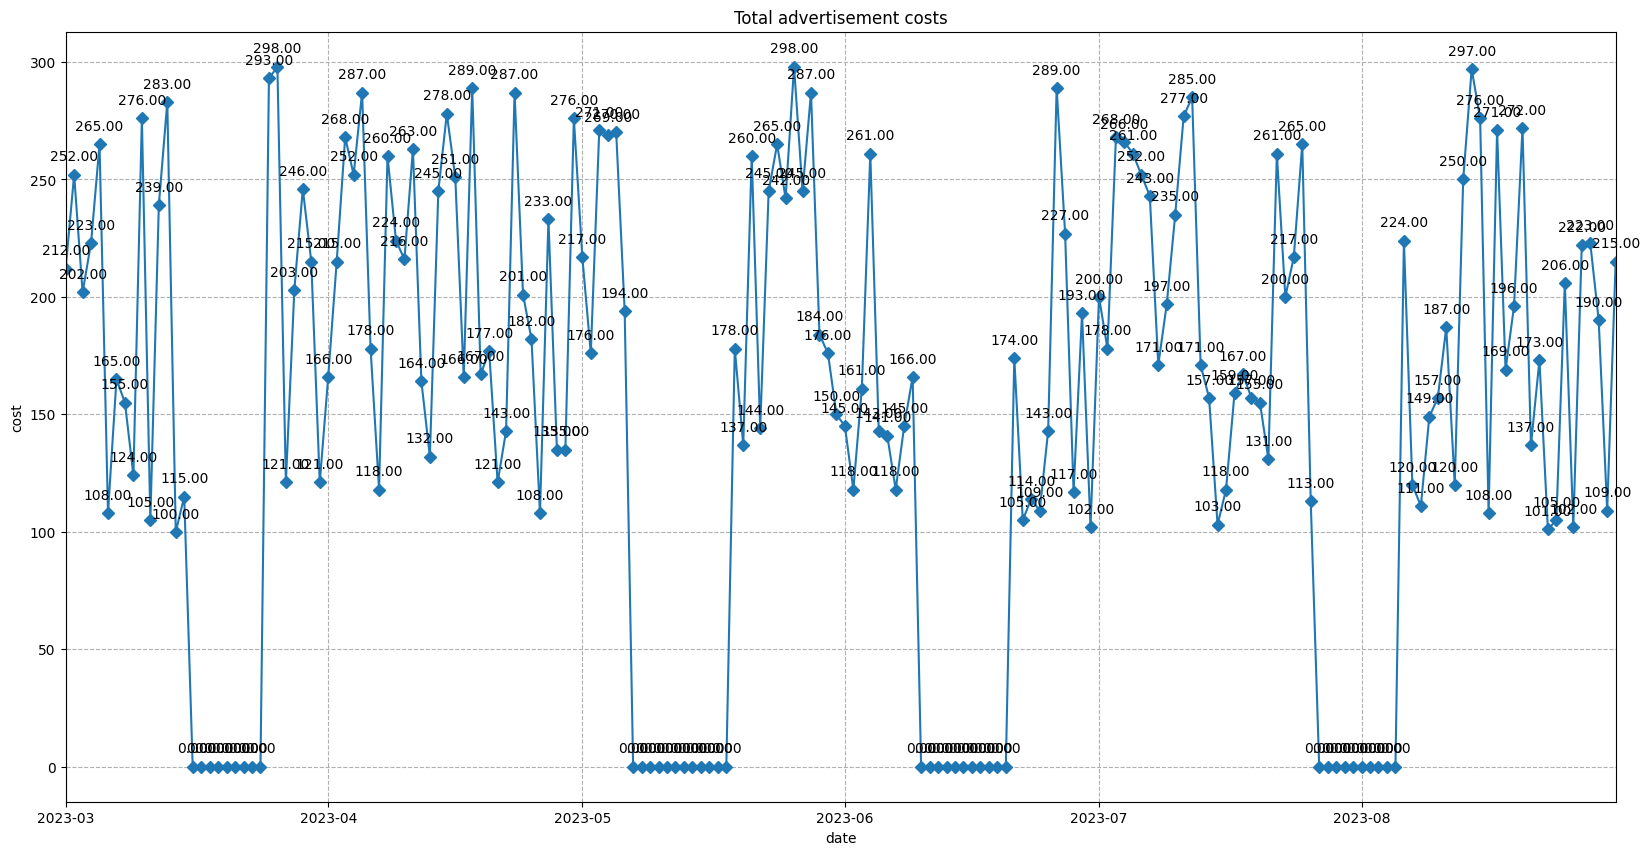

In [232]:
# Стоимости реклам
x = united_df['date_group']
y = united_df['cost']

fig, ax = plt.subplots(figsize=(20, 10))

total_advertisement_plot = ax.plot(x, y, marker='D')

for x, y in zip(x, y):

    label = '{:.2f}'.format(y)

    ax.annotate(label, 
                 (x, y),
                 textcoords='offset points',
                 xytext=(0,10),
                 ha='center')

ax.set_title('Total advertisement costs')
ax.set_xlabel('date')
ax.set_ylabel('cost')
ax.margins(x=0)
ax.grid(True, linestyle='dashed')
ax.set_axisbelow(True)

plt.savefig('charts/fig07.png', format='png')

plt.show()

In [219]:
# Интервалы рекламных кампаний
ads = united_df[united_df['utm_campaign'] != 'none'].groupby('utm_campaign')['date_group'].agg(['min', 'max']).reset_index()
ads = ads.sort_values(by='min').reset_index(drop=True)

ads.head()

,utm_campaign,min,max
0,advanced_algorithms_series,2023-03-01,2023-03-15
1,virtual_reality_workshop,2023-03-25,2023-05-06
2,ui_ux_design_drive,2023-05-19,2023-06-09
3,women_in_tech_symposium,2023-06-21,2023-07-26
4,intro_to_python_course,2023-08-06,2023-08-31


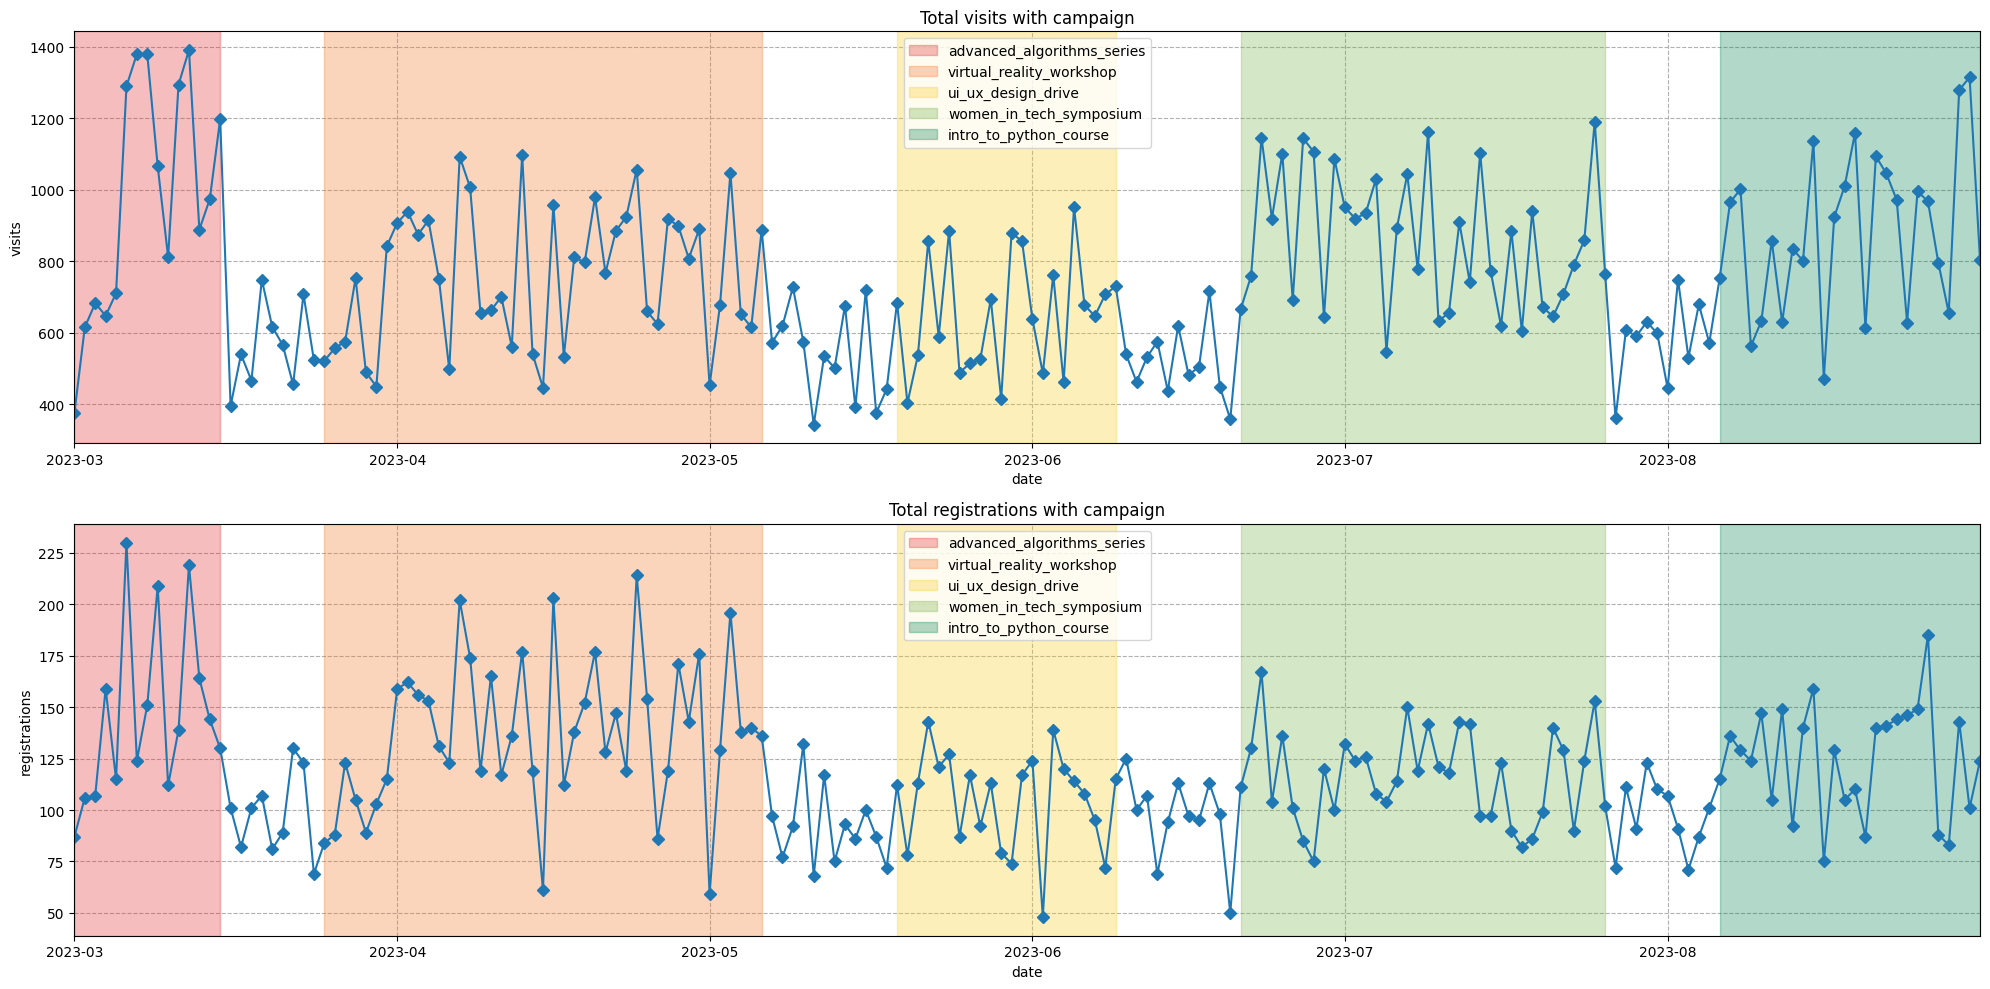

In [240]:
# Визиты и регистрации с выделением рекламных кампаний
x = united_df['date_group']
y_1 = united_df['visits']
y_2 = united_df['registrations']

color_palette = [
    '#e12729',
    '#f37324',
    '#f8cc1b',
    '#72b043',
    '#007f4e'
]

count_1 = 0
count_2 = 0

fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1, layout='tight')

for id, row in ads.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[count_1]
    count_1 += 1
    ax[0].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[0].plot(x, y_1, marker='D')
ax[0].set_title('Total visits with campaign')
ax[0].set_xlabel('date')
ax[0].set_ylabel('visits')
ax[0].margins(x=0)
ax[0].grid(True, linestyle='dashed')
ax[0].set_axisbelow(True)
ax[0].legend()

for id, row in ads.iterrows():
    x0 = row['min']
    x1 = row['max']
    annotation_text = row['utm_campaign']
    color=color_palette[count_2]
    count_2 += 1
    ax[1].axvspan(x0, x1, color=color, alpha = 0.3, label = annotation_text)

ax[1].plot(x, y_2, marker='D')
ax[1].set_title('Total registrations with campaign')
ax[1].set_xlabel('date')
ax[1].set_ylabel('registrations')
ax[1].margins(x=0)
ax[1].grid(True, linestyle='dashed')
ax[1].set_axisbelow(True)
ax[1].legend()

plt.savefig('charts/fig08.png', format='png')

plt.show()